## Load Libraries

In [1]:
# !pip install fastparquet

In [2]:
# !pip install imblearn

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from datetime import date, timedelta

In [3]:
import pandas as pd
import numpy as np

from imblearn.over_sampling import RandomOverSampler
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from catboost import CatBoostClassifier, Pool

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
# Custom metric
from metrics_f1 import calc_f1_score

## Load Data

In [82]:
# Загрузка данных, собранных c июля 2022 по январь 2023

path_train = r"./"

# данные по дислокации
dislok = pd.read_parquet(path_train + '/dislok_wagons.parquet').convert_dtypes()
# данные по текущим ремонтам
pr_rem = pd.read_parquet(path_train + '/pr_rems.parquet').convert_dtypes()
# список вагонов с остаточным пробегом на момент прогноза
wag_prob = pd.read_parquet(path_train + '/wagons_probeg_ownersip.parquet').convert_dtypes()
# параметры вагона
wag_param = pd.read_parquet(path_train + '/wag_params.parquet').convert_dtypes()
# таргет по прогноза выбытия вагонов в ПР на месяц и на 10 дней
target = pd.read_csv(path_train +'/target/y_train.csv').convert_dtypes()
# текущие ремонты вагонов
tr_rem = pd.read_parquet(path_train + '/tr_rems.parquet').convert_dtypes()
# данные по КТИ
kti_izm = pd.read_parquet(path_train + '/kti_izm.parquet').convert_dtypes()

In [83]:
# Загрузка данных, собранных в феврале 2023

path_train = r"test"

dislok_feb = pd.read_parquet(path_train + '/dislok_wagons.parquet').convert_dtypes()
pr_rem_feb = pd.read_parquet(path_train + '/pr_rems.parquet').convert_dtypes()
wag_prob_feb = pd.read_parquet(path_train + '/wagons_probeg_ownersip.parquet').convert_dtypes()
wag_param_feb = pd.read_parquet(path_train + '/wag_params.parquet').convert_dtypes()
target_feb = pd.read_csv(path_train +'/target/y_test.csv').convert_dtypes()
tr_rem_feb = pd.read_parquet(path_train + '/tr_rems.parquet').convert_dtypes()
kti_izm_feb = pd.read_parquet(path_train + '/kti_izm.parquet').convert_dtypes()

## Minimal Data Preprocessing

In [86]:
# Соединяем данные в один датафрейм
target = pd.concat([target, target_feb])

data_df = pd.DataFrame()
month_uniq = sorted(list(target['month'].value_counts().index))

# Присваиваем метки классов для данных каждого следующего месяца предыдущему
# Для установки соответствия объект - класс, предсказанный по нему
for i, date in enumerate(month_uniq[:-1]):
    month_f = target[target['month'] == month_uniq[i]]
    month_s = target[target['month'] == month_uniq[i + 1]]
    
    month_f = month_f.drop(columns=['target_month', 'target_day'])
    month_f = month_f.merge(month_s.drop(columns=['month']), 
                            on='wagnum', how='left')
    data_df = pd.concat([data_df, month_f])
    
data_df = data_df.fillna(0)

In [87]:
# предобработка данных из других датафреймов
# фича 'wagnum_month' нужна, чтобы оставить по 1 записи каждого вагона в каджый месяц

dislok['month_number'] = pd.to_datetime(dislok['plan_date']).dt.month
dislok['wagnum_month'] = dislok['wagnum'].astype(str) + " " + dislok['month_number'].astype(str)
dislok = dislok.sort_values(by='plan_date')
dislok = dislok.drop_duplicates(subset = 'wagnum_month', keep='first')

wag_prob['wagnum_month'] = wag_prob['wagnum'].astype(str) + " " + wag_prob['month'].astype(str)
wag_prob = wag_prob.drop_duplicates(subset = 'wagnum_month', keep='first')

kti_izm['wagnum_month'] = kti_izm['wagnum'].astype(str) + " " + pd.to_datetime(kti_izm['operation_date_dttm']).dt.month.astype(str)
kti_izm = kti_izm.drop(columns='operation_date_dttm')
kti_izm = kti_izm.groupby('wagnum_month').mean().reset_index()

In [88]:
#предобработка данных из других датафреймов для февраля

dislok_feb['month_number'] = pd.to_datetime(dislok_feb['plan_date']).dt.month
dislok_feb['wagnum_month'] = dislok_feb['wagnum'].astype(str) + " " + dislok_feb['month_number'].astype(str)
dislok_feb = dislok_feb.sort_values(by='plan_date')
dislok_feb = dislok_feb.drop_duplicates(subset = 'wagnum_month', keep='first')

wag_prob_feb['wagnum_month'] = wag_prob_feb['wagnum'].astype(str) + " " + wag_prob_feb['month'].astype(str)
wag_prob_feb = wag_prob_feb.drop_duplicates(subset = 'wagnum_month', keep='first')

kti_izm_feb['wagnum_month'] = kti_izm_feb['wagnum'].astype(str) + " " + pd.to_datetime(kti_izm_feb['operation_date_dttm']).dt.month.astype(str)
kti_izm_feb = kti_izm_feb.drop(columns='operation_date_dttm')
kti_izm_feb = kti_izm_feb.groupby('wagnum_month').mean().reset_index()

In [89]:
data_df['wagnum_month'] = data_df['wagnum'].astype(str) + " " + pd.to_datetime(data_df['month']).dt.month.astype(str)

data_df_feb = target[target.month == '2023-02-01'].drop(columns = ['target_month', 'target_day'])
data_df_feb['wagnum_month'] = data_df_feb['wagnum'].astype(str) + " " + pd.to_datetime(data_df_feb['month']).dt.month.astype(str)

In [90]:
# Сливаем данные из нескольких таблиц

data = data_df.merge(wag_param, how='left', on='wagnum')
data = data.merge(dislok[['date_kap', 'date_dep', 'wagnum_month']], on='wagnum_month', how='left')
data = data.merge(wag_prob[['ost_prob', 'wagnum_month']], on='wagnum_month', how='left')
data = data.merge(kti_izm.drop(['wagnum'], axis = 1), on='wagnum_month', how='left')

In [91]:
#Сливаем данные для февраля

data_feb = data_df_feb.merge(wag_param_feb, how='left', on='wagnum')
data_feb = data_feb.merge(dislok_feb[['date_kap', 'date_dep', 'wagnum_month']], on='wagnum_month', how='left')
data_feb = data_feb.merge(wag_prob_feb[['ost_prob', 'wagnum_month']], on='wagnum_month', how='left')
data_feb = data_feb.merge(kti_izm_feb.drop(['wagnum'], axis = 1), on='wagnum_month', how='left')

In [92]:
# Приведение типов

data['wagnum'] = data['wagnum'].astype('object')
data['ost_prob'] = data['ost_prob'].astype(float)

data_feb['wagnum'] = data_feb['wagnum'].astype('object')
data_feb['ost_prob'] = data_feb['ost_prob'].astype(float)

izm_features = data.columns[28:44]
data[izm_features] = data[izm_features].astype(float)
izm_features = data_feb.columns[26:42]
data_feb[izm_features] = data_feb[izm_features].astype(float)

data['mileage_all'] = data['mileage_all'].astype(float)
data['cnsi_volumek'] = data['cnsi_volumek'].astype(float)

data_feb['mileage_all'] = data_feb['mileage_all'].astype(float)
data_feb['cnsi_volumek'] = data_feb['cnsi_volumek'].astype(float)

int_features = data.dtypes[data.dtypes=='Int64'].reset_index().iloc[:,0].values
data[int_features] = data[int_features].astype(float) 
int_features = data_feb.dtypes[data_feb.dtypes=='Int64'].reset_index().iloc[:,0].values
data_feb[int_features] = data_feb[int_features].astype(float) 

In [93]:
# Еще некоторые фичи
data['month'] = pd.to_datetime(data['month'])
data['month_n'] = data['month'].dt.month.astype('object')

cols2drop = ['date_iskl', 'tippogl']
data = data.drop(columns=cols2drop)

# Сколько дней прошло с ремонтов
data['days_kap'] = (data['month'] - data['date_kap']).dt.days
data['days_dep'] = (data['month'] - data['date_dep']).dt.days
data.drop(['date_dep', 'date_kap'], axis = 1, inplace = True)
#data.head()

In [94]:
# аналогично для данных за февраль

data_feb['month'] = pd.to_datetime(data_feb['month'])
data_feb['month_n'] = data_feb['month'].dt.month.astype('object')

cols2drop = ['date_iskl', 'tippogl']
data_feb = data_feb.drop(columns=cols2drop)

# Сколько дней прошло с ремонтов
data_feb['days_kap'] = (data_feb['month'] - data_feb['date_kap']).dt.days
data_feb['days_dep'] = (data_feb['month'] - data_feb['date_dep']).dt.days
data_feb.drop(['date_dep', 'date_kap'], axis = 1, inplace = True)
#data.head()

## Minimal EDA

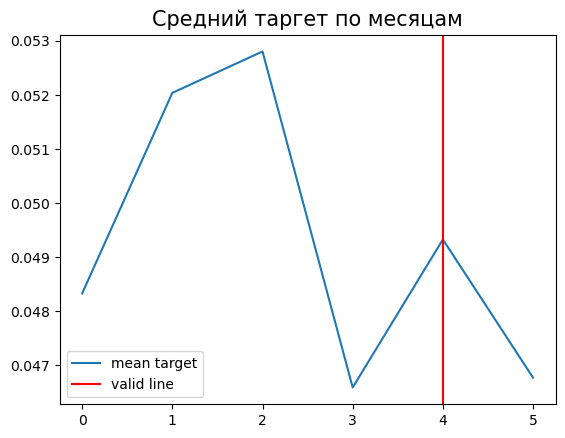

In [95]:
# Как изменяется таргет по месяцам

mean_target_by_month = data.groupby(
    'month_n', sort=False
).agg({'target_month': 'mean'})
mean_target_by_month = mean_target_by_month.reset_index(drop=True)

plt.plot(mean_target_by_month, label='mean target');
plt.axvline(x=4, color='r', label='valid line')
plt.title("Средний таргет по месяцам", size=15);
plt.legend();

## Train/Test Split

In [96]:
target_cols = ['target_month', 'target_day']

X = data.drop(columns=target_cols)
y = data[target_cols]

X_train, y_train = X, y
X_holdout = data_feb 

In [97]:
# Получаем типы столбцов
dtypes = X_train.dtypes

dt_cols = list(dtypes[(dtypes == "datetime64[ms]") | (dtypes == "datetime64[ns]")].index)
num_cols = list(dtypes[dtypes == "float64"].index)
object_cols = list(dtypes[(dtypes == "string") | (dtypes == "object")].index)

In [98]:
# Проверка соответствия типов
assert len(object_cols) + len(dt_cols) + len(num_cols) + len(target_cols) == len(data.columns), "Не совпадают размерности!"

In [99]:
len(data.columns)

43

## Random Over Sampler

In [100]:
# Результат с ROS оказался хуже

# y_train_month = y_train['target_month'].astype(int)
# y_train_day = y_train['target_day'].astype(int)
# ros = RandomOverSampler(random_state=17)
# X_train, y_train_month = ros.fit_resample(X_train, y_train_month)
# y_train['target_month'].value_counts()

In [101]:
# y_train_month.value_counts()

## CatBoost 1 model

#### Модель, для предсказаний на 30 дней

In [102]:
X_train[object_cols] = X_train[object_cols].astype('object')
X_holdout[object_cols] = X_holdout[object_cols].astype('object')

In [105]:
# Пул для обучения модели
features = num_cols + object_cols

first_pool = Pool(
    data=X_train[features],
    label=y_train['target_month'],
    # label=y_train_month,
    cat_features=object_cols,
)
#first_eval_pool = Pool(
#     data=X_holdout[features], 
#     label=y_holdout['target_month'].astype(int),
#     cat_features=object_cols,
#)

In [ ]:
# Не дало положительных результатов
# class_weights = (y_train_month.value_counts()[0] / y_train_month.shape[0],
#                  y_train_month.value_counts()[1] / y_train_month.shape[0])

In [106]:
# Параметры модели
model_params = dict(
    iterations=250,
    learning_rate=0.13,
    random_state=17,
    loss_function='Logloss',
    # class_weights=class_weights,
    eval_metric='F1',
    l2_leaf_reg = 1.21,
    depth = 6
)

base_model = CatBoostClassifier(**model_params)

In [107]:
# Обучение модели
base_model.fit(
    X=first_pool,
    #eval_set=first_eval_pool,
    plot=True,
    verbose=100,
    early_stopping_rounds=200
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0000000	total: 244ms	remaining: 1m
100:	learn: 0.6823729	total: 32.5s	remaining: 48s
200:	learn: 0.7462475	total: 1m 3s	remaining: 15.6s
249:	learn: 0.7562585	total: 1m 19s	remaining: 0us


In [108]:
# Получение предсказаний
first_y_pred = base_model.predict(X_holdout[features])
first_y_pred = pd.Series(first_y_pred).astype(int)
first_y_pred.value_counts()

0    31436
1     2272
dtype: int64

Text(0.5, 1.0, 'Feature Importance')

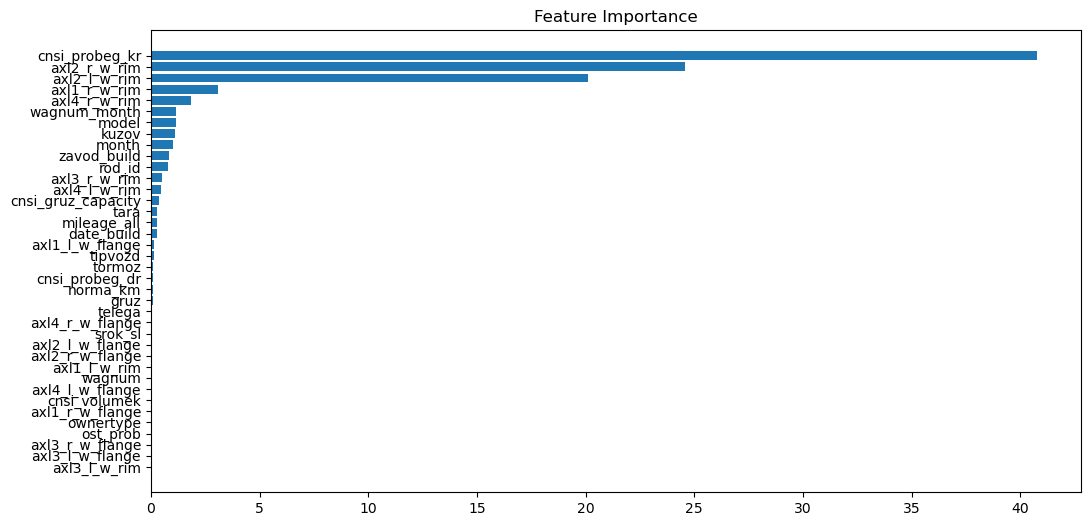

In [109]:
# Важность фич для обучения модели
feature_importance = base_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_holdout.columns)[sorted_idx])
plt.title('Feature Importance')

In [110]:
# Записываем предсказание на 30 дней
predict = X_holdout[['wagnum', 'month']].reset_index(drop=1)
predict['month_number'] = pd.to_datetime(predict['month']).dt.month
predict['wagnum_month'] = predict['wagnum'].astype(str) + " " + predict['month_number'].astype(str)
predict['target_month'] = first_y_pred

## CatBoost 2 model

#### Модель, для предсказаний на 10 дней

In [112]:
# Добавляем предсказания, полученные ранее для предсказания на 10 дней
X_holdout_2 = X_holdout.copy().reset_index(drop=1)
X_holdout_2['pred_month'] = predict['target_month']
X_holdout_2['pred_month'] = X_holdout_2['pred_month'].astype(object)
X_train_2 = X_train.copy().reset_index(drop=1)
X_train_2['pred_month'] = y_train['target_month']
X_train_2['pred_month'] = X_train_2['pred_month'].astype(int).astype(object)

In [62]:
object_cols.append('pred_month')

In [65]:
features = num_cols + object_cols

second_pool = Pool(
    data=X_train_2[features],
    label=y_train['target_day'],
    cat_features=object_cols,
)
# second_eval_pool = Pool(
#     data=X_holdout_2[features], 
#     label=y_holdout['target_day'].astype(int),
#     cat_features=object_cols,
# )

In [66]:
model_params_2 = dict(
    iterations=400,
    learning_rate=0.13,
    random_state=17,
    loss_function='Logloss',
    # class_weights=class_weights,
    eval_metric='F1',
    l2_leaf_reg = 1.0,
    depth = 6
)

base_2_model = CatBoostClassifier(**model_params_2)

In [67]:
base_2_model.fit(
    X=second_pool,
    # eval_set=second_eval_pool,
    plot=True,
    verbose=100,
    early_stopping_rounds=200
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0000000	total: 307ms	remaining: 2m 2s
100:	learn: 0.4555282	total: 29.3s	remaining: 1m 26s
200:	learn: 0.5682707	total: 59.3s	remaining: 58.7s
300:	learn: 0.6235521	total: 1m 29s	remaining: 29.4s
399:	learn: 0.6565704	total: 1m 59s	remaining: 0us


In [68]:
second_y_pred = base_2_model.predict(X_holdout_2[features])
second_y_pred = pd.Series(second_y_pred).astype(int)

In [69]:
second_y_pred.value_counts()

0    101094
1        30
dtype: int64

In [72]:
predict['target_day'] = second_y_pred
predict['month'] = predict['month'].replace('2023-02-01', '2023-03-01')
predict['wagnum'] = predict['wagnum'].astype(int)
predict = predict.drop(columns=['month_number', 'wagnum_month'])

In [74]:
predict.target_month.value_counts()

0    100716
1       408
Name: target_month, dtype: int64

In [75]:
predict.target_day.value_counts()

0    101094
1        30
Name: target_day, dtype: int64

In [76]:
# Записываем предсказания в файл
y_pred = pd.read_csv('./target/y_predict.csv')

In [77]:
y_pred

,wagnum,month
0,33361,2023-03-01
1,33364,2023-03-01
2,33366,2023-03-01
3,33358,2023-03-01
4,33349,2023-03-01
...,...,...
33702,17621,2023-03-01
33703,25045,2023-03-01
33704,27156,2023-03-01
33705,21361,2023-03-01


In [78]:
y_pred = y_pred.merge(predict.drop(columns=['month']), on='wagnum', how='left')
y_pred.to_csv('submission_night.csv', index = False)